In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from numpy.matlib import repmat
import os
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from pandas.util.version import Infinity
from math import inf
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.utils import shuffle

import random
import pickle
import pandas as pd
import numpy as np

In [3]:
dados = "/content/drive/MyDrive/smiles/BACES/train_set.csv"

Pré-Processamento dos dados

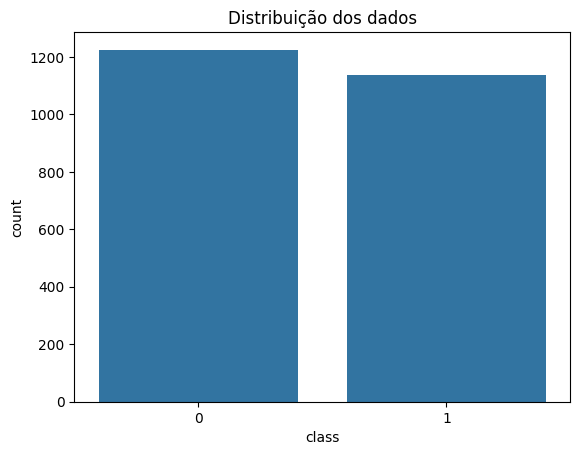

In [4]:
#carregando os dados do drive
train_set = pd.read_csv(dados, index_col='name')

# Função para calcular o fator de enriquecimento (FE)
def enrichment_factor(y_true, y_pred, top_percentage=0.01):
    df = pd.DataFrame({'true': y_true, 'pred': y_pred})
    df = df.sort_values('pred', ascending=False)
    top_n = int(len(df) * top_percentage)
    top_df = df.iloc[:top_n]
    ef = (top_df['true'].sum() / top_n) / (df['true'].sum() / len(df))
    return ef

X = train_set.iloc[:,:-1]
y = train_set.iloc[:,-1]

# Depois do balanceamento
sns.countplot(x=y)
plt.title('Distribuição dos dados')
plt.show()

In [6]:
# 1. Redução de Características
# Remover características com baixa variância
selector_var = VarianceThreshold(threshold=0.01)
X_reduced_var = selector_var.fit_transform(X)

# Selecionar as top 1000 características usando chi2
selector_kbest = SelectKBest(score_func=chi2, k=1500)
X_reduced = selector_kbest.fit_transform(X_reduced_var, y)

# 2. Redução de Amostras
# Subamostragem estratificada para reduzir o conjunto de dados pela metade
X_sub, _, y_sub, _ = train_test_split(
    X_reduced, y,
    train_size=0.75,
    stratify=y,
    random_state=42
)

# Embaralhar
X_sub, y_sub = shuffle(X_sub, y_sub, random_state=42)

# Definir valores reduzidos a serem testados para cada hiperparâmetro
param_dist = {
    'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],  # Tamanhos de camadas
    'activation': ['relu', 'tanh', 'logistic'],  # Função de ativação
    'solver': ['adam', 'sgd'],  # Método de otimização
    'alpha': [0.0001, 0.001, 0.01],  # Regularização L2
    'learning_rate_init': [0.001, 0.01, 0.1],  # Taxa de aprendizado inicial
    'max_iter': [200, 300, 500],  # Número máximo de iterações
    'random_state': [42]
}

# Instanciar o modelo
et = MLPClassifier(random_state=42)

# Configurar validação cruzada estratificada
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Usar RandomizedSearchCV com menos iterações
random_search = RandomizedSearchCV(
    estimator=et,
    param_distributions=param_dist,
    n_iter=100,  # Reduzido para 30 iterações
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'  # Use a métrica apropriada
)

# Ajustar o modelo aos dados
random_search.fit(X_sub, y_sub)

# Melhor modelo encontrado
clf = random_search.best_estimator_

# Imprimir os hiperparâmetros escolhidos
print("Melhores hiperparâmetros escolhidos:")
print(random_search.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Melhores hiperparâmetros escolhidos:
{'solver': 'adam', 'random_state': 42, 'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'relu'}
